In [1]:
import kaolin
import sys
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import polyscope as ps
import interactive_polyscope
from scipy.spatial import Voronoi, voronoi_plot_2d
from io import BytesIO
from PIL import Image
# setting path
sys.path.append('../')
import sdfpred_utils.sdfpred_utils as su
import sdfpred_utils.sdf_MLP as mlp
import sdfpred_utils.sdf_functions as sdf
import sdfpred_utils.loss_functions as lf
import trimesh
from scipy.spatial import Delaunay, Voronoi


#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))

#default tensor types
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

multires = 2
input_dims = 3
lr_sites = 0.03
lr_model = 0.0003
iterations = 5000
save_every = 100
max_iter = 100
#learning_rate = 0.03
destination = "./images/autograd/3D/"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using device:  NVIDIA GeForce RTX 3090


loaded model


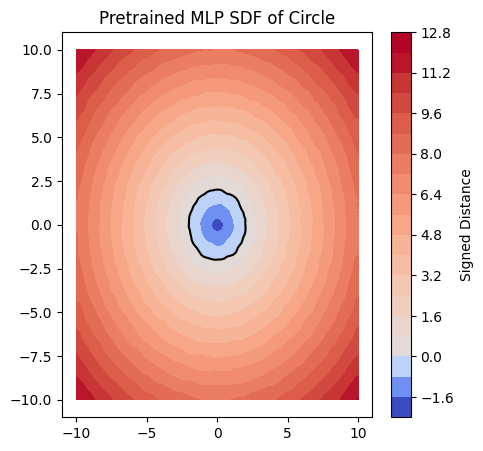

In [2]:
import matplotlib
import os

model = mlp.Decoder(multires=multires, input_dims=2).to(device)
model_path = '../models_resources/pretrained_circle.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print('loaded model')
else:
    print("no model found, pretraining")
    model.pre_train_circle(3000, radius=1.0)
    torch.save(model.state_dict(),model_path)

#plot sdf_circle_wave
fig, ax = plt.subplots(figsize=(5, 5))
xx, yy, sdf_values = sdf.plot_sdf(ax, model)

#convert sdf to numpy
sdf_values = sdf_values.cpu().detach().numpy()

norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

# Plot the SDF with the centered colormap
contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")
plt.title("Pretrained MLP SDF of Circle")
plt.xlim(-11, 11)
plt.ylim(-11, 11)

plt.show()

Voronoi ridges:  [[4 0]
 [4 9]
 [4 3]
 [5 6]
 [5 8]
 [5 0]
 [5 3]
 [3 0]
 [1 6]
 [1 8]
 [1 7]
 [8 6]
 [2 0]
 [2 9]
 [2 6]
 [2 7]
 [0 9]
 [0 6]
 [6 7]]
Voronoi rigdes vertices:  [[0, 1], [-1, 0], [-1, 1], [3, 4], [-1, 3], [4, 5], [-1, 5], [1, 5], [2, 6], [-1, 2], [-1, 6], [2, 3], [7, 8], [-1, 7], [8, 9], [-1, 9], [0, 7], [4, 8], [6, 9]]
Voronoi vertices:  [[-2.48095594 -1.5776068 ]
 [-2.61575117  1.50775578]
 [ 2.56792482  1.55894638]
 [ 1.67916587  2.09013449]
 [ 0.02710892  1.45665676]
 [-1.64502617  2.10916052]
 [ 2.57083801 -1.52494723]
 [-1.70194627 -2.04681971]
 [-0.00560474 -1.42780857]
 [ 1.63241768 -2.08336466]]
Delaunay simplices:  [[9 0 4]
 [0 3 4]
 [8 6 1]
 [5 6 8]
 [6 5 0]
 [5 3 0]
 [6 7 1]
 [2 0 9]
 [2 6 0]
 [2 7 6]]


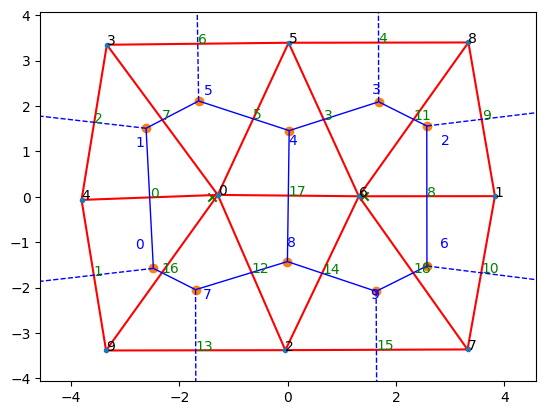

In [3]:

import numpy as np
from scipy.spatial import Delaunay, Voronoi
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import sdfpred_utils.sdfpred_utils as su



points = np.array([[-1.29121883, 0.04024019],
 [ 3.82579886,  0.01307893],
 [-0.0435634,  -3.37884161],
 [-3.34000104,  3.34717147],
 [-3.80725371, -0.0696819 ],
 [ 0.01656605,  3.39162777],
 [ 1.31297362,  0.0107052 ],
 [ 3.32053027, -3.36299312],
 [ 3.33716388,  3.39748507],
 [-3.35475875, -3.38574726]])

#points = np.array(su.createCVTgrid(num_centroids=128).detach().cpu())

voronoi_initial = Voronoi(points[:,:2])

# Compute Delaunay triangulation
delaunay_triangulation = Delaunay(points[:,:2])

#plot centroids from voronoi 
centroids = [voronoi_initial.vertices[voronoi_initial.regions[voronoi_initial.point_region[i]]].mean(axis=0) for i in range(len(points)) if voronoi_initial.regions[voronoi_initial.point_region[i]] and -1 not in voronoi_initial.regions[voronoi_initial.point_region[i]]]
centroids = np.array(centroids)

# tricentroids = []

# for i, simplex in enumerate(delaunay_triangulation.simplices):
#     simplex_points = points[simplex]
#     centroid = simplex_points.mean(axis=0)
    
#     # Store valid centroids (ensure they are inside the convex hull)
#     tricentroids.append(centroid)

# tricentroids = np.array(tricentroids)

print("Voronoi ridges: ", voronoi_initial.ridge_points)
print("Voronoi rigdes vertices: ", voronoi_initial.ridge_vertices)
print("Voronoi vertices: ", voronoi_initial.vertices)
print("Delaunay simplices: ", delaunay_triangulation.simplices)


fig, ax = plt.subplots()
voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=True, line_colors='blue')
#plot points index
for i, point in enumerate(points):
    ax.text(point[0], point[1], str(i), color='black')
    #plot points coordinates
    #ax.text(point[0], point[1], f"({point[0]:.2f}, {point[1]:.2f})", color='pink')

#plot the delaunay simplices with index
for i, simplex in enumerate(delaunay_triangulation.simplices):
    # Compute the circumcenter of the simplex
    circumcenter = np.mean(points[simplex], axis=0)
    ax.text(circumcenter[0], circumcenter[1], str(i), color='blue')

# plot the ridge points with index
for i, (point1, point2) in enumerate(voronoi_initial.ridge_points):
    # Compute the midpoint of the ridge
    midpoint = (points[point1] + points[point2]) / 2
    ax.text(midpoint[0], midpoint[1], str(i), color='green')




# # Plot the points
#plt.scatter(points[:, 0], points[:, 1], color='blue')
plt.scatter(centroids[:, 0], centroids[:, 1], color='green', marker='x', label='Centroids')
# plt.scatter(tricentroids[:, 0], tricentroids[:, 1], color='blue', marker='o', label='Delaunay Centroids')
# #change color of point 0
# plt.scatter(points[0, 0], points[0, 1], color='red')
# Plot the Delaunay triangulation
ax.triplot(points[:, 0], points[:, 1], delaunay_triangulation.simplices, color='red')
# plt.xlim(-6, 6)
# plt.ylim(-6, 6)
plt.show()

Circumcenters: {0: array([[-2.48095594, -1.5776068 ],
       [-2.61575117,  1.50775578],
       [ 0.02710892,  1.45665676],
       [-1.64502617,  2.10916052],
       [-1.70194627, -2.04681971],
       [-0.00560474, -1.42780857]]), 1: array([[ 2.56792482,  1.55894638],
       [ 2.57083801, -1.52494723]]), 2: array([[-1.70194627, -2.04681971],
       [-0.00560474, -1.42780857],
       [ 1.63241768, -2.08336466]]), 3: array([[-2.61575117,  1.50775578],
       [-1.64502617,  2.10916052]]), 4: array([[-2.48095594, -1.5776068 ],
       [-2.61575117,  1.50775578]]), 5: array([[ 1.67916587,  2.09013449],
       [ 0.02710892,  1.45665676],
       [-1.64502617,  2.10916052]]), 6: array([[ 2.56792482,  1.55894638],
       [ 1.67916587,  2.09013449],
       [ 0.02710892,  1.45665676],
       [ 2.57083801, -1.52494723],
       [-0.00560474, -1.42780857],
       [ 1.63241768, -2.08336466]]), 7: array([[ 2.57083801, -1.52494723],
       [ 1.63241768, -2.08336466]]), 8: array([[2.56792482, 1.55894638]

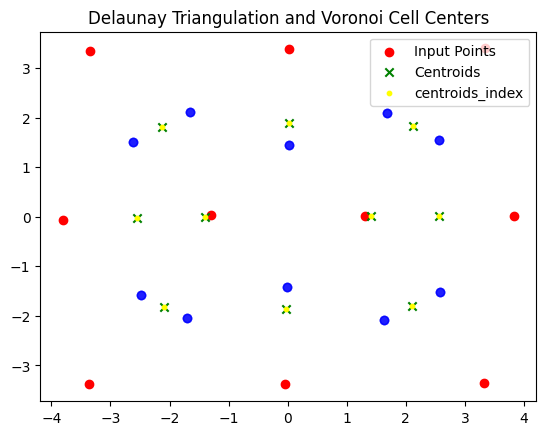

Voronoi Cell for Point 0:
  Circumcenter: [-2.48095594 -1.5776068 ]
  Circumcenter: [-2.61575117  1.50775578]
  Circumcenter: [0.02710892 1.45665676]
  Circumcenter: [-1.64502617  2.10916052]
  Circumcenter: [-1.70194627 -2.04681971]
  Circumcenter: [-0.00560474 -1.42780857]
Voronoi Cell for Point 1:
  Circumcenter: [2.56792482 1.55894638]
  Circumcenter: [ 2.57083801 -1.52494723]
Voronoi Cell for Point 2:
  Circumcenter: [-1.70194627 -2.04681971]
  Circumcenter: [-0.00560474 -1.42780857]
  Circumcenter: [ 1.63241768 -2.08336466]
Voronoi Cell for Point 3:
  Circumcenter: [-2.61575117  1.50775578]
  Circumcenter: [-1.64502617  2.10916052]
Voronoi Cell for Point 4:
  Circumcenter: [-2.48095594 -1.5776068 ]
  Circumcenter: [-2.61575117  1.50775578]
Voronoi Cell for Point 5:
  Circumcenter: [1.67916587 2.09013449]
  Circumcenter: [0.02710892 1.45665676]
  Circumcenter: [-1.64502617  2.10916052]
Voronoi Cell for Point 6:
  Circumcenter: [2.56792482 1.55894638]
  Circumcenter: [1.67916587 2.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

#TODO:

def slow_circumcenter(p1, p2, p3):
    """Calculate the circumcenter of the triangle formed by points p1, p2, p3."""
    # Coordinates of the points
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3

    # Midpoints of the edges
    D = 2 * (x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))

    # Using the determinant method to calculate the circumcenter coordinates
    ux = ((x1**2 + y1**2)*(y2 - y3) + (x2**2 + y2**2)*(y3 - y1) + (x3**2 + y3**2)*(y1 - y2)) / D
    uy = ((x1**2 + y1**2)*(x3 - x2) + (x2**2 + y2**2)*(x1 - x3) + (x3**2 + y3**2)*(x2 - x1)) / D

    return [ux, uy]

def compute_voronoi_cell_centers(delaunay):
    """Compute the Voronoi cell centers (circumcenters) for each point in the Delaunay triangulation."""
    points = delaunay.points
    circumcenters = {}

    # For each triangle in the Delaunay triangulation
    for simplex in delaunay.simplices:
        p1, p2, p3 = points[simplex]
        
        # Compute the circumcenter of the triangle
        center = slow_circumcenter(p1, p2, p3)

        # Store the circumcenter for each point involved in the triangle
        for point in simplex:
            if point not in circumcenters:
                circumcenters[point] = []
            circumcenters[point].append(center)

    # Convert lists of circumcenters to arrays
    for point in circumcenters:
        circumcenters[point] = np.array(circumcenters[point])

    return circumcenters


# def compute_voronoi_cell_centers_index_based(delaunay):
#     """Compute the Voronoi cell centers (circumcenters) for each point in the Delaunay triangulation."""
#     points = delaunay.points
#     # init a np array of length points in dim 1 and variable in dim 2
#     circumcenters = [[] for _ in range(len(points))]  # Preallocate lists
#     # Compute circumcenters
#     for simplex in delaunay.simplices:
#         center = circumcenter(*points[simplex])
#         for point_index in simplex:
#             circumcenters[point_index].append(center)

#     # Convert lists to arrays
#     return [np.array(centers) for centers in circumcenters]



def circumcenter(points, simplices):
    """Compute the circumcenters of all triangles in the Delaunay triangulation in a vectorized way."""
    p1, p2, p3 = points[simplices[:, 0]], points[simplices[:, 1]], points[simplices[:, 2]]

    # Compute determinant (D)
    D = 2 * (p1[:, 0] * (p2[:, 1] - p3[:, 1]) +
             p2[:, 0] * (p3[:, 1] - p1[:, 1]) +
             p3[:, 0] * (p1[:, 1] - p2[:, 1]))

    # Compute circumcenter coordinates
    ux = ((p1[:, 0]**2 + p1[:, 1]**2) * (p2[:, 1] - p3[:, 1]) +
          (p2[:, 0]**2 + p2[:, 1]**2) * (p3[:, 1] - p1[:, 1]) +
          (p3[:, 0]**2 + p3[:, 1]**2) * (p1[:, 1] - p2[:, 1])) / D

    uy = ((p1[:, 0]**2 + p1[:, 1]**2) * (p3[:, 0] - p2[:, 0]) +
          (p2[:, 0]**2 + p2[:, 1]**2) * (p1[:, 0] - p3[:, 0]) +
          (p3[:, 0]**2 + p3[:, 1]**2) * (p2[:, 0] - p1[:, 0])) / D

    return np.column_stack((ux, uy))

def compute_voronoi_cell_centers_index_based(delaunay):
    """Compute the Voronoi cell centers (circumcenters) for each point in a vectorized manner."""
    simplices = delaunay.simplices
    circumcenters_arr = circumcenter(delaunay.points, simplices)  # Compute all circumcenters at once

    # Flatten simplices and repeat circumcenters to map them to the points
    indices = simplices.ravel()  # Flatten simplex indices
    centers = np.repeat(circumcenters_arr, 3, axis=0)  # Repeat circumcenters for each point in the simplex

    # Create an array of lists to store circumcenters per point
    result = np.empty(len(delaunay.points), dtype=object)
    for i in range(len(result)):
        result[i] = centers[indices == i]

    return result


# # Sample input points
# points = np.random.rand(10, 2)  # Example: 10 points in 2D

# Perform Delaunay triangulation
delaunay = Delaunay(points)

# Compute Voronoi cell centers (circumcenters)
circumcenters = compute_voronoi_cell_centers(delaunay)

circumcenters_index = compute_voronoi_cell_centers_index_based(delaunay)

#sort keys
circumcenters = {k: circumcenters[k] for k in sorted(circumcenters.keys())}

print("Circumcenters:", circumcenters)
print("Index Circ:", circumcenters_index)

centroids = {}
for point, centers in circumcenters.items():
    centroids[point] = np.mean(centers, axis=0)
print("Centroids (mean position of circumcenters):", centroids)
#convert dict to numpy array
centroids = np.array(list(centroids.values()))
print("Centroids (mean position of circumcenters):", centroids)

centroids_index = []
for i in range(len(circumcenters_index)):
    centroids_index.append(np.mean(circumcenters_index[i], axis=0))
centroids_index = np.array(centroids_index)
print("Centroids (mean position of circumcenters):", centroids_index)

# Visualize the Delaunay triangulation and Voronoi cell centers
fig, ax = plt.subplots()
ax.set_title("Delaunay Triangulation and Voronoi Cell Centers")

# # Plot Delaunay triangulation
# for simplex in delaunay.simplices:
#     simplex = np.array(simplex)
#     ax.plot(points[simplex, 0], points[simplex, 1], 'k-', lw=1)

ax.scatter(points[:, 0], points[:, 1], color='red', label="Input Points")
ax.scatter(centroids[:, 0], centroids[:, 1], color='green', marker='x', label='Centroids')
ax.scatter(centroids_index[:, 0], centroids_index[:, 1], color='yellow', marker='o', s=10, label='centroids_index')

# Plot circumcenters (vertices of Voronoi cells)
for centers in circumcenters.values():
    ax.scatter(centers[:, 0], centers[:, 1], color='blue', alpha=0.5)

ax.legend()
plt.show()

# Output the circumcenters for each point
for idx, centers in circumcenters.items():
    print(f"Voronoi Cell for Point {idx}:")
    for center in centers:
        print(f"  Circumcenter: {center}")


Voronoi cells:  {'faces': [{'adjacent_cell': 2, 'vertices': [0, 5]}, {'adjacent_cell': 6, 'vertices': [0, 1]}, {'adjacent_cell': 3, 'vertices': [3, 2]}, {'adjacent_cell': 4, 'vertices': [3, 4]}, {'adjacent_cell': 5, 'vertices': [2, 1]}, {'adjacent_cell': 9, 'vertices': [5, 4]}], 'original': array([-1.29121883,  0.04024019]), 'vertices': [array([-0.00560474, -1.42780857]), array([0.02710892, 1.45665676]), array([-1.64502617,  2.10916052]), array([-2.61575117,  1.50775578]), array([-2.48095594, -1.5776068 ]), array([-1.70194627, -2.04681971])], 'volume': 9.099825349625863, 'adjacency': [[5, 1], [0, 2], [1, 3], [2, 4], [3, 5], [4, 0]]}
10 Centroids:  [[-1.40369589  0.00355633]
 [ 3.28469071  0.01521704]
 [-0.02631181 -2.71159859]
 [-2.78616937  2.66279346]
 [-3.27417678 -0.03942214]
 [ 0.01339522  2.73119035]
 [ 1.41197509  0.01160286]
 [ 2.76894056 -2.66942998]
 [ 2.78457754  2.68295758]
 [-2.77615501 -2.68186301]]


(-5.0, 5.0)

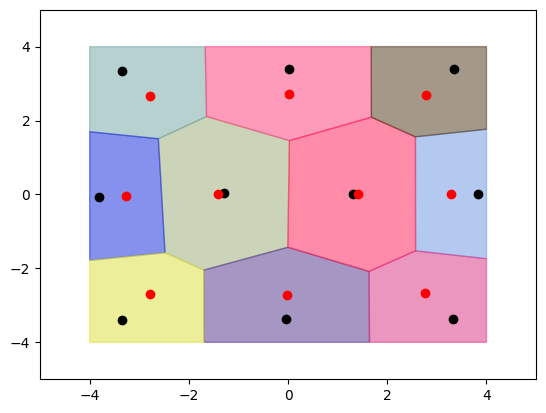

In [5]:
import pyvoro

#points = (np.random.rand(10, 2)-0.5)*4

colors = np.random.rand(len(points), 3) # or predefined 
color_map = {tuple(coords):color for coords, color in zip(points, colors)}

cells = pyvoro.compute_2d_voronoi(
  points, # point positions
  [[-4,4],[-4,4]], # limits
  2.0
)
print("Voronoi cells: ", cells[0])


#centroid of each cell is the mean position of its vertices
centroids = np.array([np.mean(cell['vertices'], axis=0) for cell in cells])

#convert centroids to numpy array
print(len(centroids), "Centroids: ", centroids)


# colorize
for i, cell in enumerate(cells):    
    polygon = cell['vertices']
    plt.fill(*zip(*polygon), color = color_map[tuple(cell['original'])], alpha=0.5)


plt.plot(points[:,0], points[:,1], 'ko')
plt.plot(centroids[:,0], centroids[:,1], 'ro')
plt.xlim(-5, 5)
plt.ylim(-5, 5)

In [6]:
ridges = voronoi_initial.ridge_points
ridges_vertices = voronoi_initial.ridge_vertices
vertices = voronoi_initial.vertices
simplices = delaunay_triangulation.simplices

sdf_values = model(torch.tensor(points, device=device))  # Assuming model outputs (N, 1) or (N,) tensor

# fix this as its the good way to do it
neighbors = torch.tensor(np.array(ridges), device=device)
all_tetrahedra = torch.tensor(np.array(simplices), device=device)

# Extract the SDF values for each site in the pair
sdf_i = sdf_values[neighbors[:, 0]]  # First site in each pair
sdf_j = sdf_values[neighbors[:, 1]]  # Second site in each pair
# Find the indices where SDF values have opposing signs or one is zero
mask = (sdf_i * sdf_j <= 0).squeeze()
zero_crossing_pairs = neighbors[mask]

print("zero_crossing_pairs_vor", zero_crossing_pairs)

# all_ridge_vertices = torch.tensor(np.array(ridges_vertices), device=device)
# ridge_vertices_pairs = all_ridge_vertices[mask]

# # from ridge_vertices_pairs create a neighbours list
# keys = torch.unique(ridge_vertices_pairs)

# #for each key append the index of the other key if present in the pair
# neighbours_dict = {}
# for key in keys:
#     neighbours_dict[key.item()] = []

# for i, pair in enumerate(ridge_vertices_pairs):

# print(neighbours_dict)

"""
WITHOUT VORONOI
Computes the indices of the sites composing vertices where neighboring sites have opposite or zero SDF values.

Args:
    sites (torch.Tensor): (N, D) tensor of site positions.
    model (callable): Function or neural network that computes SDF values.

Returns:
    zero_crossing_vertices_index (list of triplets): List of site indices (si, sj, sk) where at least 2 sites have opposing SDF signs.
"""
# Extract unique pairs of edges from Delaunay tetrahedra
neighbors = torch.tensor(np.vstack(list({tuple(sorted(edge)) for tetra in simplices for edge in zip(tetra, np.roll(tetra, -1))})), device=device)

# Extract the SDF values for each site in the pair
sdf_i = sdf_values[neighbors[:, 0]]
sdf_j = sdf_values[neighbors[:, 1]]

# Find the indices where SDF values have opposing signs or one is zero
mask_zero_crossing_sites = (sdf_i * sdf_j <= 0).squeeze()
zero_crossing_pairs = neighbors[mask_zero_crossing_sites]
print("zero_crossing_pairs_tri", zero_crossing_pairs)

zero_crossing_pairs_vor tensor([[4, 0],
        [5, 6],
        [5, 0],
        [3, 0],
        [1, 6],
        [8, 6],
        [2, 0],
        [2, 6],
        [0, 9],
        [6, 7]], dtype=torch.int32)
zero_crossing_pairs_tri tensor([[0, 2],
        [0, 5],
        [1, 6],
        [6, 8],
        [5, 6],
        [0, 4],
        [6, 7],
        [0, 3],
        [0, 9],
        [2, 6]], dtype=torch.int32)


In [7]:
zero_crossing_vertices_index = []
#convert tensor to np array
zero_crossing_pairs_list = zero_crossing_pairs.cpu().detach().numpy()

for triplet in simplices:
    triplet_pairs = {(triplet[0], triplet[1]), (triplet[1], triplet[2]), (triplet[0], triplet[2])}
    if any(pair in zero_crossing_pairs_list for pair in triplet_pairs):
        zero_crossing_vertices_index.append(triplet)
#####################
# vectorized version
simplices_tensor = torch.tensor(simplices, device = device)  # Shape: (M, 3)
sdf_i = sdf_values[simplices_tensor[:, 0]]  # First site in each pair
sdf_j = sdf_values[simplices_tensor[:, 1]]  # Second site in each pair
sdf_k = sdf_values[simplices_tensor[:, 2]]  # Third site in each pair
# Find the indices where SDF values have opposing signs or one is zero
mask = (sdf_i * sdf_j <= 0).squeeze() | (sdf_i * sdf_k <= 0).squeeze() | (sdf_j * sdf_k <= 0).squeeze()
print("mask", mask)
zero_crossing_vertices_index_vectorized = simplices_tensor[mask]
#######################

computed_v = su.compute_all_vertices(torch.tensor(points, device=device), zero_crossing_vertices_index)
vectorized_v = su.compute_vertices_2d_vectorized(torch.tensor(points, device=device),zero_crossing_vertices_index_vectorized)
#compare both arrays to see if they are the same
# must trim to 3 decimals to compare
#vertices = np.around(vertices, 3)
computed_v = computed_v.detach().cpu().numpy()
computed_v = np.around(computed_v, 3)
vectorized_v = vectorized_v.detach().cpu().numpy()
vectorized_v = np.around(vectorized_v, 3)

print("Computed vertices length: ", len(computed_v))
print("Vectorized vertices length: ", len(vectorized_v))
print("Vectorized_V and Computed_V: ", np.array_equal(vectorized_v, computed_v))

mask tensor([True, True, True, True, True, True, True, True, True, True])
Computed vertices length:  10
Vectorized vertices length:  10
Vectorized_V and Computed_V:  True


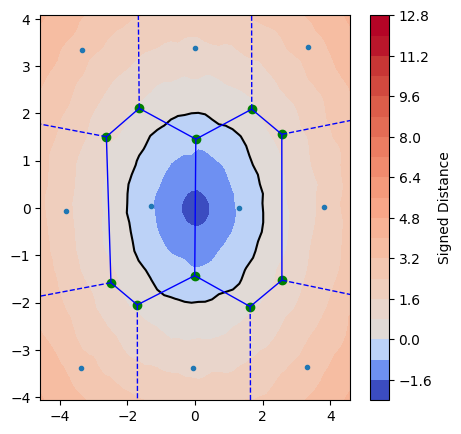

In [8]:
#plot sdf_circle_wave
fig, ax = plt.subplots(figsize=(5, 5))
xx, yy, sdf_values = sdf.plot_sdf(ax, model)

#convert sdf to numpy
sdf_values = sdf_values.cpu().detach().numpy()

norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

# Plot the SDF with the centered colormap
contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")

voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
#plot points index
for i, point in enumerate(points):
    #ax.text(point[0], point[1], str(i), color='black')
    #plot points coordinates
    #ax.text(point[0], point[1], f"({point[0]:.2f}, {point[1]:.2f})", color='pink')
    continue

#plot the delaunay simplices with index
for i, simplex in enumerate(delaunay_triangulation.simplices):
    #Compute the circumcenter of the simplex
    circumcenter = np.mean(points[simplex], axis=0)
    #ax.text(circumcenter[0], circumcenter[1], str(i), color='blue')

#plot the ridge points with index
for i, (point1, point2) in enumerate(voronoi_initial.ridge_points):
    #Compute the midpoint of the ridge
    midpoint = (points[point1] + points[point2]) / 2
    #ax.text(midpoint[0], midpoint[1], str(i), color='green')


#Plot the Delaunay triangulation
#ax.triplot(points[:, 0], points[:, 1], delaunay_triangulation.simplices, color='red')

#scatter vectorized_v
plt.scatter(vectorized_v[:, 0], vectorized_v[:, 1], color='green')
# scatter computed
#plt.scatter(computed_v[:, 0], computed_v[:, 1], color='yellow')

plt.show()

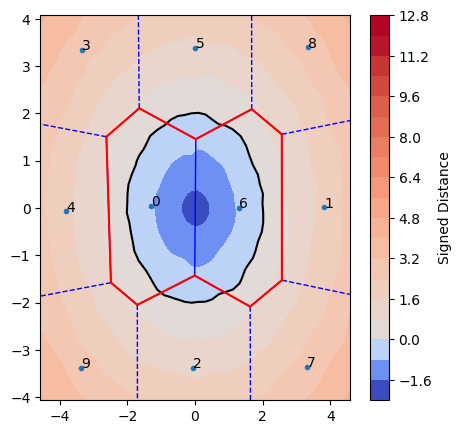

In [9]:
#Meshing test

#plot sdf_circle_wave
fig, ax = plt.subplots(figsize=(5, 5))
xx, yy, sdf_values = sdf.plot_sdf(ax, model)

#convert sdf to numpy
sdf_values = sdf_values.cpu().detach().numpy()

norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

# Plot the SDF with the centered colormap
contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")

voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
#plot points index
for i, point in enumerate(points):
    ax.text(point[0], point[1], str(i), color='black')
    #plot points coordinates
    #ax.text(point[0], point[1], f"({point[0]:.2f}, {point[1]:.2f})", color='pink')
    continue

#plot the delaunay simplices with index
for i, simplex in enumerate(delaunay_triangulation.simplices):
    #Compute the circumcenter of the simplex
    circumcenter = np.mean(points[simplex], axis=0)
    #ax.text(circumcenter[0], circumcenter[1], str(i), color='blue')

#plot the ridge points with index
for i, (point1, point2) in enumerate(voronoi_initial.ridge_points):
    #Compute the midpoint of the ridge
    midpoint = (points[point1] + points[point2]) / 2
    #ax.text(midpoint[0], midpoint[1], str(i), color='green')


ridges = voronoi_initial.ridge_points
ridges_vertices = voronoi_initial.ridge_vertices
vertices = voronoi_initial.vertices
simplices = delaunay_triangulation.simplices

sdf_values = model(torch.tensor(points, device=device))  # Assuming model outputs (N, 1) or (N,) tensor

# Compute the Delaunay tessellation
tri = Delaunay(points)
vor = Voronoi(points)


neighbors = torch.tensor(np.array(vor.ridge_points), device=device)
neighbors_vertices = torch.tensor(np.array(vor.ridge_vertices), device=device)
#all_tetrahedra = torch.tensor(np.array(tri.simplices), device=device)

# Extract the SDF values for each site in the pair
sdf_i = sdf_values[neighbors[:, 0]]  # First site in each pair
sdf_j = sdf_values[neighbors[:, 1]]  # Second site in each pair
# Find the indices where SDF values have opposing signs or one is zero
mask_zero_crossing_sites = (sdf_i * sdf_j <= 0).squeeze()
zero_crossing_pairs = neighbors[mask_zero_crossing_sites]
faces = neighbors_vertices[mask_zero_crossing_sites]
faces = faces.cpu().detach().numpy()
mesh_vertices = voronoi_initial.vertices

#print(faces)
#print(mesh_vertices)

for face in faces:
#connect the two vertices in face
    plt.plot([mesh_vertices[face[0]][0], mesh_vertices[face[1]][0]], [mesh_vertices[face[0]][1], mesh_vertices[face[1]][1]], 'r-')


def get_zero_crossing_mesh_3d(sites, model):
    sites_np = sites.detach().cpu().numpy()
    vor = Voronoi(sites_np)  # Compute 3D Voronoi diagram

    sdf_values = model(sites)[:, 0].detach().cpu().numpy()  # Compute SDF values

    valid_faces = []  # List of polygonal faces
    used_vertices = set()  # Set of indices for valid vertices

    for (point1, point2), ridge_vertices in zip(vor.ridge_points, vor.ridge_vertices):
        if -1 in ridge_vertices:
            continue  # Skip infinite ridges

        # Check if SDF changes sign across this ridge
        if np.sign(sdf_values[point1]) != np.sign(sdf_values[point2]):
            valid_faces.append(ridge_vertices)
            used_vertices.update(ridge_vertices)

    # **Filter Voronoi vertices**
    used_vertices = sorted(used_vertices)  # Keep unique, sorted indices
    vertex_map = {old_idx: new_idx for new_idx, old_idx in enumerate(used_vertices)}
    filtered_vertices = vor.vertices[used_vertices]

    # **Re-index faces to match the new filtered vertex list**
    filtered_faces = [[vertex_map[v] for v in face] for face in valid_faces]

    return filtered_vertices, filtered_faces

vert, face = get_zero_crossing_mesh_3d(torch.tensor(points, device=device), model)

# for face in faces: # Plot each face
#     plt.plot([vert[face[0]][0], vert[face[1]][0]], [vert[face[0]][1], vert[face[1]][1]], 'g-')


plt.show()

In [10]:
#Todo vectorize
def compute_cvt_loss(sites, model):
    # Convert sites to NumPy for Voronoi computation
    sites_np = sites.detach().cpu().numpy()
    vor = Voronoi(sites_np)
    sdf_values = model(sites)
    

    centroids = []
    valid_indices = []

    for i in range(len(sites_np)):
        region_index = vor.point_region[i]
        region = vor.regions[region_index]

        # Ensure the region is valid (finite and non-empty)
        if region and -1 not in region:
            vertices = vor.vertices[region]
            centroid = vertices.mean(axis=0)  # Compute centroid
            centroids.append(centroid)
            valid_indices.append(i)  # Store indices of valid centroids

    # Convert centroids to a PyTorch tensor
    centroids = torch.tensor(np.array(centroids), device=sites.device, dtype=sites.dtype)

    # Select only valid sites for loss computation
    valid_sites = sites[valid_indices]
    
    
    sdf_weights = 1 / (1 + torch.abs(sdf_values[valid_indices]))

    # Compute Mean Squared Error (MSE) loss
    #cvt_loss = torch.mean(torch.norm(valid_sites - centroids, p=2, dim=1) ** 2)
    cvt_loss = torch.mean(((valid_sites - centroids)*sdf_weights)**2)
    
    print("cvt_loss: ", cvt_loss)
    return cvt_loss

def compute_cvt_loss_vectorized(sites, model):
    # Convert sites to NumPy for Voronoi computation
    sdf_values = model(sites)
    sites_np = sites.detach().cpu().numpy()
    vor = Voronoi(sites_np)
        
    # create a nested list of vertices for each site
    centroids = [vor.vertices[vor.regions[vor.point_region[i]]].mean(axis=0) for i in range(len(sites_np)) if vor.regions[vor.point_region[i]] and -1 not in vor.regions[vor.point_region[i]]]
    centroids = torch.tensor(np.array(centroids), device=sites.device, dtype=sites.dtype)
    valid_indices = torch.tensor([i for i in range(len(sites_np)) if vor.regions[vor.point_region[i]] and -1 not in vor.regions[vor.point_region[i]]], device=sites.device)
    
    valid_sites = sites[valid_indices]
    sdf_weights = 1 / (1 + torch.abs(sdf_values[valid_indices]))
    
    cvt_loss = torch.mean(((valid_sites - centroids)*sdf_weights)**2)
    
    print("cvt_loss: ", cvt_loss)
    return cvt_loss

import cProfile, pstats
import time
profiler = cProfile.Profile()
profiler.enable()

cvt_loss = compute_cvt_loss(torch.tensor(points, device=device), model)
cvt_loss_vectorized = compute_cvt_loss_vectorized(torch.tensor(points, device=device), model)

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()

cvt_loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
cvt_loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
         879 function calls (853 primitive calls) in 0.019 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    0.019    0.006 /home/wylliam/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3490(run_code)
        3    0.000    0.000    0.019    0.006 {built-in method builtins.exec}
        1    0.000    0.000    0.017    0.017 /tmp/ipykernel_495460/1883951781.py:63(<module>)
        1    0.000    0.000    0.017    0.017 /tmp/ipykernel_495460/1883951781.py:2(compute_cvt_loss)
        2    0.000    0.000    0.010    0.005 {built-in method builtins.print}
        2    0.000    0.000    0.010    0.005 /home/wylliam/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torch/_tensor.py:420(__repr__)
        2    0.000    0.000    0.010    0.005 /home/wylliam/anacond

In [11]:
import torch
from scipy.spatial import Delaunay

def circumcenter_torch(points, simplices):
    """Compute the circumcenters for 2D triangles or 3D tetrahedra in a vectorized manner using PyTorch."""
    points = torch.tensor(points, dtype=torch.float32)
    simplices = torch.tensor(simplices, dtype=torch.long) 
    
    if points.shape[1] == 2:  # **2D Case (Triangles)**
        # points = torch.tensor(points, dtype=torch.float32)
        # simplices = torch.tensor(simplices, dtype=torch.long)
            
        p1, p2, p3 = points[simplices[:, 0]], points[simplices[:, 1]], points[simplices[:, 2]]
        
        # Compute determinant (D)
        D = 2 * (p1[:, 0] * (p2[:, 1] - p3[:, 1]) +
                 p2[:, 0] * (p3[:, 1] - p1[:, 1]) +
                 p3[:, 0] * (p1[:, 1] - p2[:, 1]))

        # Compute circumcenter coordinates
        ux = ((p1[:, 0]**2 + p1[:, 1]**2) * (p2[:, 1] - p3[:, 1]) +
              (p2[:, 0]**2 + p2[:, 1]**2) * (p3[:, 1] - p1[:, 1]) +
              (p3[:, 0]**2 + p3[:, 1]**2) * (p1[:, 1] - p2[:, 1])) / D

        uy = ((p1[:, 0]**2 + p1[:, 1]**2) * (p3[:, 0] - p2[:, 0]) +
              (p2[:, 0]**2 + p2[:, 1]**2) * (p1[:, 0] - p3[:, 0]) +
              (p3[:, 0]**2 + p3[:, 1]**2) * (p2[:, 0] - p1[:, 0])) / D

        return torch.stack((ux, uy), dim=1)
       
    elif points.shape[1] == 3:  # **3D Case (Tetrahedra)**
        """
        Compute the circumcenters of multiple tetrahedra in a 3D Delaunay triangulation.

        Parameters:
        points : tensor of shape (N, 3)
            The 3D coordinates of all input points.
        simplices : tensor of shape (M, 4)
            Indices of tetrahedron vertices in `points`.

        Returns:
        circumcenters : tensor of shape (M, 3)
            The circumcenters of all tetrahedra.
        """
        # Extract tetrahedral vertices using broadcasting
        A = points[simplices[:, 0]]  # Shape: (M, 3)
        B = points[simplices[:, 1]]
        C = points[simplices[:, 2]]
        D = points[simplices[:, 3]]

        # Compute edge vectors relative to A
        BA = B - A  # Shape: (M, 3)
        CA = C - A
        DA = D - A

        # Compute squared edge lengths
        len_BA = torch.sum(BA**2, axis=1, keepdims=True)  # Shape: (M, 1)
        len_CA = torch.sum(CA**2, axis=1, keepdims=True)
        len_DA = torch.sum(DA**2, axis=1, keepdims=True)

        # Compute cross products
        cross_CD = torch.cross(CA, DA)  # Shape: (M, 3)
        cross_DB = torch.cross(DA, BA)
        cross_BC = torch.cross(BA, CA)

        # Compute denominator (scalar for each tetrahedron)
        denominator = 0.5 / torch.sum(BA * cross_CD, axis=1, keepdims=True)  # Shape: (M, 1)

        # Compute circumcenter offsets
        circ_offset = (
            len_BA * cross_CD +
            len_CA * cross_DB +
            len_DA * cross_BC
        ) * denominator  # Shape: (M, 3)

        # Compute circumcenters
        circumcenters = A + circ_offset  # Shape: (M, 3)

        return circumcenters
    else:
        raise ValueError("Only 2D (triangles) and 3D (tetrahedra) are supported.")


def compute_voronoi_cell_centers_index_based_torch(delau):
    """Compute Voronoi cell centers (circumcenters) for 2D or 3D Delaunay triangulation in PyTorch."""
    #simplices = torch.tensor(delaunay.simplices, dtype=torch.long)
    simplices = delau.simplices
    #points = torch.tensor(delaunay.points, dtype=torch.float32)
    points = delau.points
    
    # Compute all circumcenters at once (supports both 2D & 3D)
    circumcenters_arr = circumcenter_torch(points, simplices)
    # Flatten simplices and repeat circumcenters to map them to the points
    indices = simplices.flatten()  # Flatten simplex indices
    centers = circumcenters_arr.repeat_interleave(simplices.shape[1], dim=0)  # Repeat for each vertex in simplex

    print("indices shape", indices.shape) #shape M,
    print("centers shape", centers.shape) #shape M,3

    # Group circumcenters per point
    # result = [centers[indices == i] for i in range(len(points))]
    
    # centroids = torch.stack([torch.mean(c, dim=0) for c in result])

    # Vectorized approach M,M matrix too big
    M = len(points)
    # mask = torch.tensor(indices).unsqueeze(0) == torch.arange(M).unsqueeze(1)  # Shape (M, M), boolean mask
    # grouped_centers = mask.float() @ centers  # Shape (M, 3), sum of relevant centers
    # counts = mask.sum(dim=1, keepdim=True).clamp(min=1)  # Avoid division by zero
    # centroids = grouped_centers / counts  # Compute mean

    # Compute the sum of centers for each index
    indices = torch.tensor(indices)
    # Compute the sum of centers for each index
    centroids = torch.zeros(M, 3,dtype=torch.float32, device=centers.device)
    counts = torch.zeros(M, device=centers.device)

    centroids.index_add_(0, indices, centers)  # Sum centers per unique index
    counts.index_add_(0, indices, torch.ones(centers.shape[0], device=centers.device))  # Count occurrences

    centroids /= counts.clamp(min=1).unsqueeze(1)  # Avoid division by zero

    return centroids




import numpy as np
from scipy.spatial import Delaunay, Voronoi
import polyscope as ps

# Generate random 3D points
seed = 42
np.random.seed(seed)
points_3d = np.random.rand(10, 3)


noise_scale = 0.5
domain_limit = 1.5
num_centroids = 3*3*3
x = torch.linspace(-domain_limit, domain_limit, int(round(num_centroids**(1/3))))
y = torch.linspace(-domain_limit, domain_limit, int(round(num_centroids**(1/3))))
z = torch.linspace(-domain_limit, domain_limit, int(round(num_centroids**(1/3))))
meshgrid = torch.meshgrid(x, y, z)
meshgrid = torch.stack(meshgrid, dim=3).view(-1, 3)
#add noise to meshgrid
meshgrid += torch.randn_like(meshgrid) * noise_scale
points_3d = np.array(meshgrid.cpu().numpy())


delaunay_3d = Delaunay(points_3d)
vor = Voronoi(points_3d)
points_3d = torch.tensor(points_3d, dtype=torch.float32)

# Compute circumcenters
voronoi_centers_3d = compute_voronoi_cell_centers_index_based_torch(delaunay_3d)
penalties = torch.where(abs(points_3d - voronoi_centers_3d) < 10, points_3d - voronoi_centers_3d, torch.tensor(0.0))
cvt_loss = torch.mean(penalties**2)
print("CVT loss: ", cvt_loss)


#print vertices of first site
centroids = [vor.vertices[vor.regions[vor.point_region[i]]].mean(axis=0) for i in range(len(points_3d)) if vor.regions[vor.point_region[i]] and -1 not in vor.regions[vor.point_region[i]]]
centroids = np.array(centroids)
penalties = np.where(abs(points_3d - voronoi_centers_3d) < 10, points_3d - voronoi_centers_3d, np.array(0.0))
cvt_loss = np.mean(penalties**2)
print("CVT loss: ", cvt_loss)

# print("centroids vor shape", centroids.shape)
# print("Centroids vor", centroids)
# print("Centroids delau1", voronoi_centers_3d)



ps.init()
ps.register_point_cloud("points", points_3d)
ps.register_point_cloud("centroids_delaunay", voronoi_centers_3d)
ps.register_point_cloud("centroids", centroids)
# ps.register_point_cloud("points", points_3d)
# ps.register_point_cloud("vertcies", vor.vertices)
# ps.register_point_cloud("circumcenters", circumcenters_3d)
# ps.show()

indices shape (420,)
centers shape torch.Size([420, 3])
CVT loss:  tensor(2.7177, dtype=torch.float32)


/home/wylliam/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402412426/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
#Test diffvoronoi
import diffvoronoi
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d
seed = 42
dim = 3
p = 100000
np.random.seed(seed)
points_3d = np.random.rand(p, dim)


300000 points
300000


In [ ]:
d3dsimplices = diffvoronoi.get_delaunay_simplices(points_3d.reshape(dim*p)) 

#d3dpoints = np.array(d3dpoints).reshape(-1, 3)
d3dsimplices = np.array(d3dsimplices)
d3dsimplices = np.sort(d3dsimplices, axis=1)
d3dsimplices = np.sort(d3dsimplices, axis=0)

print("Diffvoronoi simplices: ", d3dsimplices)
print(len(d3dsimplices))




delaunay_3d = Delaunay(points_3d)
#print("Delaunay simplices: ", delaunay_3d.simplices)
#sort simplices on axis 1 then 0
delaunay_3d.simplices = np.sort(delaunay_3d.simplices, axis=1)
delaunay_3d.simplices = np.sort(delaunay_3d.simplices, axis=0)
print("Delaunay simplices: ", delaunay_3d.simplices)
print(len(delaunay_3d.simplices))




#compare both arrays to see if they are the same
delaunay_3d.simplices = delaunay_3d.simplices.flatten()
d3dsimplices = d3dsimplices.flatten()
# print("Delaunay simplices: ", delaunay_3d.simplices)
# print("Diffvoronoi simplices: ", d3dsimplices)
print("Delaunay and Diffvoronoi simplices are equal: ", np.array_equal(delaunay_3d.simplices, d3dsimplices))

Diffvoronoi simplices:  [[    0    84   641  4605]
 [    0    84   641  4656]
 [    0    84  1223  5041]
 ...
 [96193 98504 99960 99999]
 [96514 98520 99960 99999]
 [96611 98520 99960 99999]]
672037
Delaunay simplices:  [[    0    84   641  4605]
 [    0    84   641  4656]
 [    0    84  1223  5041]
 ...
 [96193 98504 99960 99999]
 [96514 98520 99960 99999]
 [96611 98520 99960 99999]]
672037
Delaunay and Diffvoronoi simplices are equal:  True
